#### Installing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)
from sklearn import feature_extraction, feature_selection, model_selection

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from imblearn.over_sampling import RandomOverSampler
sampler=RandomOverSampler()

from sklearn.model_selection import train_test_split
def create_train_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42069)
    return X_train, X_test, Y_train, Y_test

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def sparseTFIDF(X_train, X_test, Y_train):
    vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)
    
    #Extract Vocabulary
    corpus = X_train["preprocessed_posts"].values.astype(str)
    vectorizer.fit(corpus)
    X_training = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_

    #FEATURE SELECTION
    #Reduce Dimensionality for sparse data with Chi-Quadrat
    X_names = vectorizer.get_feature_names_out()
    p_value_limit = 0.95
    features = pd.DataFrame()

    for cat in np.unique(Y_train):
        chi2, p = feature_selection.chi2(X_training, Y_train == cat)
        features = features.append(pd.DataFrame(
            {"feature": X_names, "score": 1 - p, "y": cat}))
        features = features.sort_values(["y", "score"], ascending=[True, False])
        features = features[features["score"] > p_value_limit]
    X_names = features["feature"].unique().tolist()

    #Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
    vectorizer = TfidfVectorizer(vocabulary=X_names)
    vectorizer.fit(corpus)

    df_tfidfvect = vectorizer.transform(corpus)
    tfidf_tokens = vectorizer.get_feature_names()
    df_tfidfvect = pd.DataFrame(data = df_tfidfvect.toarray(),columns = tfidf_tokens)


    corpus = X_test["preprocessed_posts"].values.astype(str)
    df_tfidfvect_test = vectorizer.transform(corpus)
    dic_vocabulary = vectorizer.vocabulary_

    tfidf_tokens_test = vectorizer.get_feature_names()
    df_tfidfvect_test = pd.DataFrame(data = df_tfidfvect_test.toarray(),columns = tfidf_tokens_test)

    return df_tfidfvect, df_tfidfvect_test

plot-confusion-matrix function from class

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

#### Load preprocessed Data Frame

In [4]:
df = pd.read_csv('mbti_preprocessed_complete.csv')
display(df.head())

,Unnamed: 0,type,posts,encodedType,preprocessed_posts,extro_intro,intu_obs,feel_think,prosp_judg
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8,"['youtube', 'tumblr', 'enfp', 'intj', 'moment'...",0,1,1,0
1,1,ENTP,'I'm finding the lack of me in these posts ver...,3,"['im', 'finding', 'the', 'lack', 'of', 'post',...",1,1,0,1
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,11,"['good', 'one', 'youtube', 'of', 'course', 'i'...",0,1,0,1
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10,"['dear', 'intp', 'i', 'enjoyed', 'conversation...",0,1,0,0
4,4,ENTJ,'You're fired.|||That's another silly misconce...,2,"['youre', 'fired', 'thats', 'another', 'silly'...",1,1,0,0


Select columns which will serve as target and training data. Here target is the 16 MBTI categories.

In [5]:
Y = df.iloc[:,3].values
X = pd.DataFrame(df.iloc[:,4])

Split into train and test datasets.

In [6]:
X_train, X_test, Y_train, Y_test = create_train_test_split(X, Y)

In [7]:
df_tfidfvect, df_tfidfvect_test = sparseTFIDF(X_train, X_test, Y_train)

/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_1329/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_1329/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_1329/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features = features.append(pd.DataFrame(
/var/folders/kh/405kw3wn56x2htwrgh2yhcfw0000gn/T/ipykernel_1329/3762352402.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features 

### Models: Centroides and KNN (TF-IDF)

In [8]:
pipeline = Pipeline([ ('estimator', None) ]) 

#### Centroids
##### Grid Search - Hyperparameter Tuning

In [9]:
parameters = {
    'metric':['euclidean', 'manhattan'],
    'shrink_threshold':[None, 0.2]
}

gs = GridSearchCV(NearestCentroid(), parameters, scoring='accuracy', cv=cv, return_train_score=False)

gs.fit(df_tfidfvect, Y_train)
results = pd.DataFrame(gs.cv_results_)

print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.519433465085639 with params {'metric': 'euclidean', 'shrink_threshold': None}


Set the Hyperparameters according to best score.

In [10]:
pipeline.set_params(estimator=NearestCentroid(
    metric = 'euclidean',
    shrink_threshold = None
))

Pipeline(steps=[('estimator', NearestCentroid())])

##### Model

Classification Report:
              precision    recall  f1-score   support

        INFJ       0.29      0.60      0.40        55
        ENTP       0.47      0.48      0.47       212
        INTP       0.43      0.62      0.51        74
        INTJ       0.54      0.65      0.59       196
        ENTJ       0.09      0.55      0.16        11
        ENFJ       0.06      0.29      0.11        14
        INFP       0.16      0.82      0.27        11
        ENFP       0.26      0.64      0.37        28
        ISFP       0.66      0.41      0.51       436
        ISTP       0.65      0.49      0.56       545
        ISFJ       0.73      0.44      0.55       365
        ISTJ       0.57      0.53      0.55       378
        ESTP       0.44      0.74      0.55        58
        ESFP       0.36      0.53      0.43        73
        ESTJ       0.41      0.62      0.50        61
        ESFJ       0.48      0.72      0.57        86

    accuracy                           0.51      2603
   

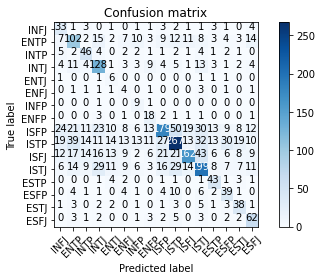

In [11]:
pipeline.fit(df_tfidfvect, Y_train)
prediction = pipeline.predict(df_tfidfvect_test)

print("Classification Report:")
print(classification_report(Y_test, prediction, target_names=df['type'].unique()))

cnf = confusion_matrix(Y_test, prediction)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = df['type'].unique())

#### KNN
##### Grid Search - Hyperparameter Tuning

In [12]:
parameters = {
    'n_neighbors':range(1,200,10),
    'algorithm':['auto','brute'],
    'weights':['uniform', 'distance'],
    'metric':['minkowski', 'cityblock', 'cosine', 'euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsClassifier(),
                  parameters,
                  scoring='accuracy',
                  cv=cv,
                  return_train_score=False)

gs.fit(df_tfidfvect, Y_train)
results = pd.DataFrame(gs.cv_results_)

print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.5265151515151515 with params {'algorithm': 'auto', 'metric': 'cityblock', 'n_neighbors': 91, 'weights': 'distance'}


In [13]:
pipeline.set_params(estimator=KNeighborsClassifier(
    n_neighbors=91,
    algorithm='auto',
    weights='distance',
    metric='cityblock'
))

Pipeline(steps=[('estimator',
                 KNeighborsClassifier(metric='cityblock', n_neighbors=91,
                                      weights='distance'))])

##### Model

Classification Report:
              precision    recall  f1-score   support

        INFJ       0.49      0.36      0.42        55
        ENTP       0.63      0.27      0.38       212
        INTP       0.58      0.47      0.52        74
        INTJ       0.56      0.66      0.61       196
        ENTJ       0.67      0.18      0.29        11
        ENFJ       0.00      0.00      0.00        14
        INFP       0.00      0.00      0.00        11
        ENFP       0.73      0.39      0.51        28
        ISFP       0.50      0.51      0.50       436
        ISTP       0.45      0.72      0.55       545
        ISFJ       0.73      0.38      0.50       365
        ISTJ       0.53      0.52      0.52       378
        ESTP       0.56      0.50      0.53        58
        ESFP       0.47      0.37      0.42        73
        ESTJ       0.44      0.49      0.47        61
        ESFJ       0.46      0.59      0.52        86

    accuracy                           0.51      2603
   

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


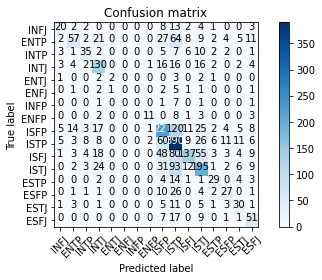

In [14]:
pipeline.fit(df_tfidfvect, Y_train)
prediction = pipeline.predict(df_tfidfvect_test)
    
print(f"Classification Report:")
print(classification_report(Y_test, prediction, target_names=df['type'].unique()))
    
cnf = confusion_matrix(Y_test, prediction)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = df['type'].unique()) 